In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 28 15:04:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    22W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18316199250351330161
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15223357440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12772488665530508704
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [ ]:
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dropout, Activation, MaxPooling1D

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/licenta')

Mounted at /content/drive


In [ ]:
train_df_path = "data/mono_en_es_train.tsv"
test_df_path = "data/mono_en_es_test.tsv"

train_df = pd.read_csv(train_df_path, sep='\t')
test_df = pd.read_csv(test_df_path, sep='\t')

In [ ]:
train_df

,iid,src,native_speaker,original,dest,text,direct,label
0,20030618:3-157:6:7,en,1,"Finally, on safety reports and some of the tec...",en,"Finally, on safety reports and some of the tec...",1,0
1,20010405:4-079:2:4,en,1,However great our desire may be to prosecute c...,en,However great our desire may be to prosecute c...,1,0
2,20030212:3-234:5:7,en,0,It then it goes on to give a number of recomme...,en,It then it goes on to give a number of recomme...,1,0
3,20030902:2-311:3:6,en,1,"Thirdly, the by-catch allowed to be kept by th...",en,"Thirdly, the by-catch allowed to be kept by th...",1,0
4,20000906:3-268:0:6,en,0,I would refer the honourable Member to the let...,en,I would refer the honourable Member to the let...,1,0
...,...,...,...,...,...,...,...,...
29575,20000119:3-126:7:8,es,1,"Creo que podría, en cambio, aceptar la oferta ...",en,"Alternatively, it could accept the offer of an...",1,1
29576,20020117:4-026:4:6,es,1,Creo sinceramente que con un mercado único y c...,en,I sincerely believe that with our internal mar...,1,1
29577,20020702:2-333:0:5,es,1,"Señor Presidente, el informe Van Lancker habla...",en,"Mr President, the Van Lancker report talks abo...",1,1
29578,20030902:2-324:7:9,es,1,La evaluación intermedia del programa DAPHNE h...,en,The mid-term assessment of the DAPHNE Programm...,1,1


In [ ]:
train = train_df[['text','label']]
test = test_df[['text','label']]

In [ ]:
print(train.shape)
print(test.shape)

(29580, 2)
(6344, 2)


In [ ]:
train_df.src.value_counts()

en    14790
es    14790
Name: src, dtype: int64

In [ ]:
from nltk.stem import PorterStemmer

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Apply stemming using the Porter stemmer
    stemmer = PorterStemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    text = ' '.join(stemmed_words)

    return text

In [ ]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}


In [ ]:

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)


def clean_text(texts):
    cleaned_text = []
    for text in texts:
        text = str(text)
        # if url links then don't append to avoid news articles
        # also check text length, save those > 10 (length of words)
        if re.match("(\w+:\/\/\S+)", text) == None and len(text) > 10:
            # removing, emojis
            text = ' '.join(
                re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)", " ", text).split())

            # fix weirdly encoded texts
            text = ftfy.fix_text(text)

            # expand contraction
            text = expandContractions(text)

            # remove punctuation
            text = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", text).split())

            # stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(text)
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            text = ' '.join(filtered_sentence)

            # stemming words
            text = PorterStemmer().stem(text)

            cleaned_text.append(text)

    return cleaned_text

# Reproducibility
np.random.seed(1234)

MAX_SEQUENCE_LENGTH = 140 # Max text size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

train_arr = [x for x in train['text']]
test_arr = [x for x in test['text']]
X_d = clean_text(train_arr)
X_r = clean_text(test_arr)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)


word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))


data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Found 28960 unique tokens
Shape of data_d tensor: (29580, 140)
Shape of data_r tensor: (6344, 140)


In [ ]:
# Load the pre-trained model using one of the Python libraries
import gensim.downloader as api
word2vec = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.key_to_index and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

# Assigning labels to the depressive tweets and random tweets data
labels_d = train['label']

labels_r = test['label']

# Splitting the arrays into test, validation, and train
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

In [ ]:

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine train and test data
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [ ]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Bidirectional, LSTM,Dense
import tensorflow as tf

with tf.device('/device:GPU:0'):
  model = Sequential()
  # Embedded layer
  model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                              input_length=MAX_SEQUENCE_LENGTH, trainable=False))
  # Convolutional Layer
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  # BiLSTM Layer
  model.add(Bidirectional(LSTM(300)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 140, 300)          6000000   
                                                                 
 conv1d_4 (Conv1D)           (None, 140, 32)           28832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 70, 32)           0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 70, 32)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 600)              799200    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 600)              

In [ ]:
print(data_train.shape)

(28739, 140)


Epoch 1/10
719/719 [==============================] - 8s 11ms/step - loss: 0.4727 - acc: 0.7742
Epoch 2/10
719/719 [==============================] - 8s 11ms/step - loss: 0.3920 - acc: 0.8220
Epoch 3/10
719/719 [==============================] - 8s 11ms/step - loss: 0.3490 - acc: 0.8459
Epoch 4/10
719/719 [==============================] - 8s 11ms/step - loss: 0.3148 - acc: 0.8624
Epoch 5/10
719/719 [==============================] - 7s 10ms/step - loss: 0.2856 - acc: 0.8791
Epoch 6/10
719/719 [==============================] - 8s 11ms/step - loss: 0.2615 - acc: 0.8912
Epoch 7/10
719/719 [==============================] - 8s 11ms/step - loss: 0.2430 - acc: 0.8998
Epoch 8/10
719/719 [==============================] - 8s 11ms/step - loss: 0.2191 - acc: 0.9109
Epoch 9/10
719/719 [==============================] - 8s 11ms/step - loss: 0.2074 - acc: 0.9145
Epoch 10/10
719/719 [==============================] - 7s 10ms/step - loss: 0.1941 - acc: 0.9194
dict_keys(['loss', 'acc'])


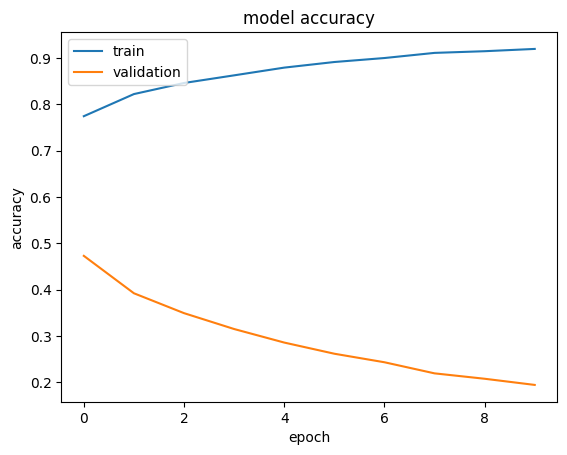

CPU times: user 1min 41s, sys: 11.2 s, total: 1min 52s
Wall time: 1min 17s


In [ ]:

%%time
with tf.device('/device:GPU:0'):
  early_stop = EarlyStopping(monitor='loss', patience=3)

  hist = model.fit(data_train, labels_train, validation_data=(data_val, labels_val),epochs=EPOCHS, batch_size=40, shuffle=True)
#plot_model(model, to_file='model.png')
print(hist.history.keys())
plt.plot(hist.history['acc'])
plt.plot(hist.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plt.plot(hist.history['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


In [ ]:
data_test.shape

(7185, 140)

In [ ]:

labels_pred = model.predict(data_test)
print(labels_pred.shape)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

print(classification_report(labels_test, labels_pred))


225/225 [==============================] - 1s 4ms/step
(7185, 1)
Accuracy: 81.70%
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      3543
           1       0.79      0.87      0.83      3642

    accuracy                           0.82      7185
   macro avg       0.82      0.82      0.82      7185
weighted avg       0.82      0.82      0.82      7185



## BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.9 MB/s eta 0:00:00


In [ ]:
%%time

import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification


with tf.device('/device:GPU:0'):

  # Load the pre-trained BERT tokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  # Load the pre-trained BERT model with a classification head
  model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

  # Compile the model
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

  # Tokenize and encode the input text data
  #encoded_input = tokenizer(data_train, padding=True, truncation=True, max_length=128, return_tensors='tf')

  early_stop = EarlyStopping(monitor='loss', patience=3)
  # Train the model
  hist = model.fit(data_train, labels_train, epochs=10,validation_data=(data_val, labels_val), batch_size=32,callbacks=[early_stop])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
899/899 [==============================] - 323s 308ms/step - loss: 0.6966 - accuracy: 0.5120
Epoch 2/10
899/899 [==============================] - 265s 295ms/step - loss: 0.6971 - accuracy: 0.4996
Epoch 3/10
899/899 [==============================] - 265s 295ms/step - loss: 0.6960 - accuracy: 0.5002
Epoch 4/10
899/899 [==============================] - 264s 294ms/step - loss: 0.6966 - accuracy: 0.4927
Epoch 5/10
869/899 [===========================>..] - ETA: 8s - loss: 0.6945 - accuracy: 0.5013

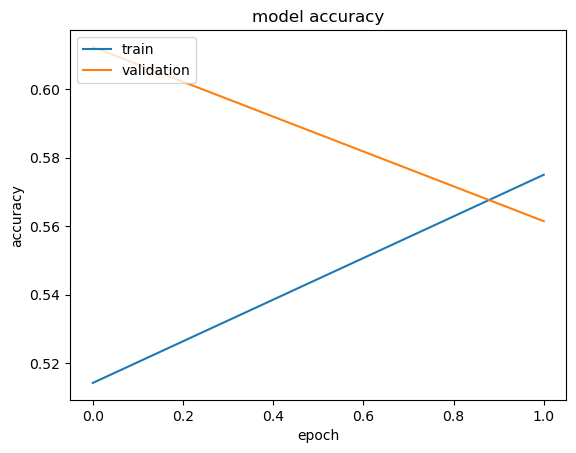

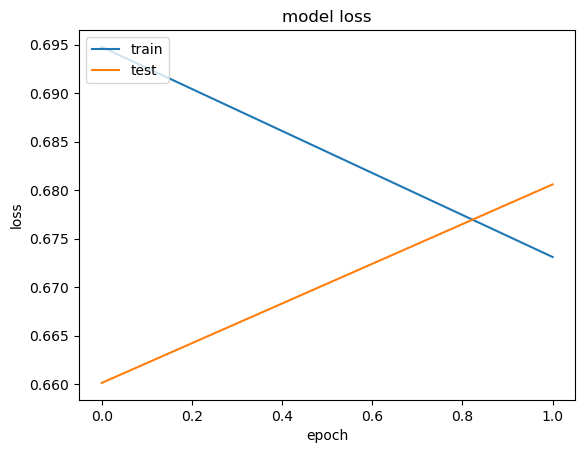

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## BERT using pytorch FRAMEWORK

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Set the optimizer, loss function, and evaluation metric
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
metric_fn = torch.nn.functional.accuracy

# Tokenize and encode the input text data
input_ids = []
attention_masks = []
for text in data_train:
    encoded_dict = tokenizer.encode_plus(
                    text,                      
                    add_special_tokens = True, 
                    max_length = 128,          
                    padding = 'max_length',
                    truncation=True,
                    return_attention_mask = True,
                    return_tensors = 'pt'
               )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_train = torch.tensor(labels_train)

# Create the DataLoader for training data
train_dataset = TensorDataset(input_ids, attention_masks, labels_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train the model
model.train()
for epoch in range(10):
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
    loss = outputs.loss
    logits = outputs.logits
    loss.backward()
    optimizer.step()
    preds = torch.argmax(logits, dim=1)
    acc = metric_fn(preds, b_labels)
    print(f"Epoch {epoch}, Batch {step}, Loss {loss.item()}, Accuracy {acc.item()}")



KeyboardInterrupt: 